In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [10]:
y_train = pd.read_csv('../data/y_train.csv', index_col = 'key_value')

## Ensamble - Promedio Ponderado

In [16]:
train = pd.read_pickle('../data/train_1628features.pkl')
test = pd.read_pickle('../data/test_1628features.pkl')

### Considerando todas las variables

In [17]:
learner_lightgbm = LGBMClassifier(n_estimators=1000, max_depth=6, boosting_type='gbdt',
                                  min_child_samples=1000)
learner_lightgbm.fit(train, y_train.target, eval_metric="auc", verbose=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=1000, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [18]:
learner_catboost = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC',
                                      max_depth = 6)
learner_catboost.fit(train, y_train,  early_stopping_rounds=10, verbose=False)

In [19]:
test_probs_catboost = pd.Series(learner_catboost.predict_proba(test)[:, -1], index=test.index, name="target")
test_probs_lightgbm = pd.Series(learner_lightgbm.predict_proba(test)[:, -1], index=test.index, name="target")
test_probs_mean_all = test_probs_catboost*0.4 + test_probs_lightgbm*0.6
test_probs_mean_all.name = 'target'
test_probs_mean_all.shape

(396666,)

In [28]:
test_probs_mean_all.to_csv('../results/test_probs_mean_all.csv')

In [20]:
del learner_lightgbm, learner_catboost, test_probs_lightgbm,  test_probs_catboost

### considerando 500 variables importantes de cada modelo

In [54]:
fi = pd.read_pickle('fi_catboost.pkl')
features_importances_lightgbm = list(fi.sort_values(ascending=False).head(500).index)
learner_lightgbm = LGBMClassifier(n_estimators=1000, max_depth=6, boosting_type='gbdt', 
                                  min_child_samples=1000)
learner_lightgbm.fit(train[features_importances_lightgbm], y_train.target, eval_metric="auc", verbose=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=6,
               min_child_samples=1000, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [55]:
fi = pd.read_pickle('fi_catboost.pkl')
features_importances_catboost = list(fi.sort_values(ascending=False).head(500).index)
learner_catboost = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', 
                                      max_depth = 6)
learner_catboost.fit(train[features_importances_catboost], y_train,  early_stopping_rounds=10, verbose=False)

In [56]:
test_probs_catboost = pd.Series(learner_catboost.predict_proba(test[features_importances_catboost])[:, -1], index=test.index, name="target")
test_probs_lightgbm = pd.Series(learner_lightgbm.predict_proba(test[features_importances_lightgbm])[:, -1], index=test.index, name="target")
test_probs_mean_500 = test_probs_catboost*0.4 + test_probs_lightgbm*0.6
test_probs_mean_500.name = 'target'
test_probs_mean_500.shape

(396666,)

In [57]:
test_probs_mean_500.to_csv('../results/test_probs_mean_500.csv')

In [26]:
del learner_lightgbm, learner_catboost, test_probs_lightgbm,  test_probs_catboost

## Stacking Models

In [81]:
train_probs_lightgbm = pd.read_pickle('train_probs_lightgbm.pkl')
train_probs_lightgbm_cf = pd.read_pickle('train_probs_lightgbm_cf.pkl')
train_probs_catboost = pd.read_pickle('train_probs_catboost.pkl')
train_probs_gbc = pd.read_pickle('train_probs_gbc.pkl')

test_probs_lightgbm = pd.read_pickle('test_probs_lightgbm.pkl')
test_probs_lightgbm_cf = pd.read_pickle('test_probs_lightgbm_cf.pkl')
test_probs_catboost = pd.read_pickle('test_probs_catboost.pkl')
test_probs_gbc = pd.read_pickle('test_probs_gbc.pkl')

In [82]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
def cross_validate_learning_rate(estimator, x_train, y_train, cv = 5, scoring = 'roc_auc', return_train_score = True):
    results = cross_validate(estimator,
                            x_train,
                            y_train,
                            cv = cv,
                            scoring=scoring,
                            return_train_score = return_train_score ) 
    train_scores = results['train_score']
    test_scores = results['test_score']
    print("train_scores: {}".format(np.mean(train_scores)))
    print("test_scores: {}".format(np.mean(test_scores)))

    lc = learning_curve(estimator, 
                        x_train, 
                        y_train, 
                        cv=cv, 
                        scoring=scoring)
    samples, train, test = lc[0],lc[1],lc[2]
    plt.plot(samples, np.mean(train, axis=1))
    plt.plot(samples, np.mean(test, axis=1))

In [83]:
from sklearn.model_selection import GridSearchCV
def grid_search_param(X, y,nfolds, param_grid, model_sklearn, scoring = 'roc_auc'):
    grid_search = GridSearchCV(model_sklearn, param_grid, cv=nfolds, return_train_score=True, scoring=scoring)
    grid_search.fit(X, y)
    return grid_search

In [84]:
train_probs_total = pd.concat([train_probs_lightgbm,train_probs_lightgbm_cf, train_probs_catboost, train_probs_gbc], axis=1)
test_probs_total =  pd.concat([test_probs_lightgbm,test_probs_lightgbm_cf, test_probs_catboost, test_probs_gbc], axis=1)
train_probs_total.columns = ['probs_lightgbm', 'probs_lightgbm_cf', 'probs_catboost','probs_gbc']
test_probs_total.columns = ['probs_lightgbm', 'probs_lightgbm_cf', 'probs_catboost', 'probs_gbc']

In [85]:
display(train_probs_total.corr(), test_probs_total.corr())

,probs_lightgbm,probs_lightgbm_cf,probs_catboost,probs_gbc
probs_lightgbm,1.000000,0.984022,0.980579,0.947272
probs_lightgbm_cf,0.984022,1.000000,0.976215,0.945748
probs_catboost,0.980579,0.976215,1.000000,0.953825
probs_gbc,0.947272,0.945748,0.953825,1.000000


,probs_lightgbm,probs_lightgbm_cf,probs_catboost,probs_gbc
probs_lightgbm,1.000000,0.993128,0.990232,0.971843
probs_lightgbm_cf,0.993128,1.000000,0.987340,0.971278
probs_catboost,0.990232,0.987340,1.000000,0.976242
probs_gbc,0.971843,0.971278,0.976242,1.000000


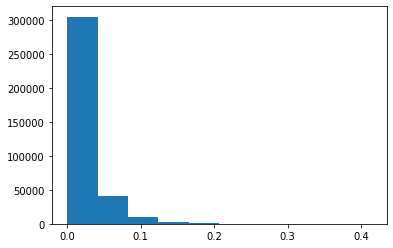

In [86]:
import matplotlib.pyplot as plt
plt.hist(np.std(train_probs_total.values, axis=1));

train_scores: 0.8550515587785382
test_scores: 0.8550275501218397


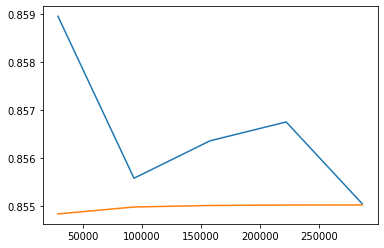

In [87]:
from sklearn.linear_model import LogisticRegression
### definir los parametros a tunear
train = train
Cs = [0.1, 0.3, 0.8, 0.9, 1.0]
# https://neurtu.readthedocs.io/examples/logistic_regression_scaling.html
solvers = ['lbfgs','saga','newton-cg','sag'] # newton-cg, sag, lbfgs, liblinear, saga
param_grid = {'C': Cs,'solver':solvers}
### encontrando los hiper_parámetros
fitting=grid_search_param(train_probs_total, y_train.target, 5,param_grid, LogisticRegression(penalty="l2", tol=0.0001, random_state=42), scoring='roc_auc')
### instanciar el estimador
estimator = fitting.best_estimator_
#     print(estimator)
### aplicar cross_validate y learning_rate 
cross_validate_learning_rate(estimator, train_probs_total, y_train.target, scoring='roc_auc')
# train_scores: 0.8549805030622771
# test_scores: 0.8549643288879635

# train_scores: 0.8550187861604925
# test_scores: 0.8549880915328358

# train_scores: 0.855097093888481
# test_scores: 0.8550626524877918

In [88]:
print(estimator)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [89]:
estimator.coef_

array([[ 2.72611912,  2.06748151,  2.32247299, -0.48829984]])

In [90]:
test_stacking = pd.Series(estimator.predict_proba(test_probs_total)[:,-1], index=test.index, name = 'target')
test_stacking

key_value
0         0.045155
1         0.061929
2         0.055068
3         0.608296
4         0.118015
            ...   
396661    0.069217
396662    0.153749
396663    0.196956
396664    0.057029
396665    0.058318
Name: target, Length: 396666, dtype: float64

In [91]:
test_stacking.to_csv('../results/test_stacking.csv')

## Promedio final

In [92]:
test_probs_mean_all_stacking = test_probs_mean_all*0.4 + test_stacking*0.6
test_probs_mean_all_stacking

key_value
0         0.028305
1         0.060102
2         0.047338
3         0.553070
4         0.131837
            ...   
396661    0.074560
396662    0.165494
396663    0.197027
396664    0.049624
396665    0.050562
Name: target, Length: 396666, dtype: float64

In [93]:
test_probs_mean_all_stacking.to_csv('../results/test_probs_mean_all_stacking.csv')

In [94]:
test_probs_mean_500_stacking = test_probs_mean_500*0.4 + test_stacking*0.6
test_probs_mean_500_stacking

key_value
0         0.028461
1         0.055240
2         0.048425
3         0.575214
4         0.145232
            ...   
396661    0.079864
396662    0.164179
396663    0.209078
396664    0.052040
396665    0.047103
Name: target, Length: 396666, dtype: float64

In [95]:
test_probs_mean_500_stacking.to_csv('../results/test_probs_mean_500_stacking.csv')

In [96]:
test_probs_mean_final = test_probs_mean_all_stacking*0.5 + test_probs_mean_500_stacking*0.5
test_probs_mean_final

key_value
0         0.028383
1         0.057671
2         0.047882
3         0.564142
4         0.138534
            ...   
396661    0.077212
396662    0.164836
396663    0.203053
396664    0.050832
396665    0.048833
Name: target, Length: 396666, dtype: float64

In [97]:
test_probs_mean_final.to_csv('../results/test_probs_mean_final.csv')